In [202]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd

        

path = "Matches/"
json_files = [pos_json for pos_json in os.listdir(path) if pos_json.endswith('.json')]

colnames = ["matchId", "summonerId", "teamId", "championId", "baronKills", "dragonKills", "towerKills", "userRank", 
            "matchDuration", "creepsTime", "goldTime", "damageTime", "xpTime", "kills", "deaths", "assists", "winner"]
dfdict = collections.OrderedDict((colname, []) for colname in colnames)

counter = 0
for js in json_files:
    with open(os.path.join(path, js)) as json_file:
        data = json.load(json_file, "ISO-8859-1")

    for i in data["matches"]:
        for t in i["teams"]:
            dfdict['teamId'].extend([t["teamId"]]*5)
            dfdict['baronKills'].extend([t["baronKills"]]*5)
            dfdict['dragonKills'].extend([t["dragonKills"]]*5)
            dfdict['towerKills'].extend([t["towerKills"]]*5)
        for j in i["participantIdentities"]:
            dfdict['summonerId'].append(j['player']['summonerId'])
        for k in i["participants"]:
            dfdict['championId'].append(k['championId'])
            dfdict['matchId'].append(i['matchId'])
            dfdict["matchDuration"].append(i['matchDuration'])
            dfdict['userRank'].append(k["highestAchievedSeasonTier"])
            dfdict['kills'].append(k['stats']['kills'])
            dfdict['deaths'].append(k['stats']['deaths'])
            dfdict['assists'].append(k['stats']['assists'])
            dfdict['creepsTime'].append(k['timeline']['creepsPerMinDeltas'])
            dfdict['goldTime'].append(k['timeline']['goldPerMinDeltas'])
            dfdict['damageTime'].append(k['timeline']['damageTakenPerMinDeltas'])
            dfdict['xpTime'].append(k['timeline']['xpPerMinDeltas'])
            if k['stats']['winner'] == False:
                dfdict['winner'].append(0)
            else:
                dfdict['winner'].append(1)
            
            
matchdf = pd.DataFrame(dfdict)

In [203]:
matchdf = pd.concat([matchdf.drop(['creepsTime'], axis=1), matchdf['creepsTime'].apply(pd.Series)], 
                    axis=1).rename(columns = {'zeroToTen':'creepsZeroToTen', 'tenToTwenty':'creepsTenToTwenty', 
                                              'twentyToThirty':'creepsTwentyToThirty', 
                                              'thirtyToEnd':'creepsThirtyToEnd'})
matchdf = pd.concat([matchdf.drop(['goldTime'], axis=1), matchdf['goldTime'].apply(pd.Series)], 
                    axis=1).rename(columns = {'zeroToTen':'goldZeroToTen', 'tenToTwenty':'goldTenToTwenty', 
                                              'twentyToThirty':'goldTwentyToThirty', 
                                              'thirtyToEnd':'goldThirtyToEnd'})
matchdf = pd.concat([matchdf.drop(['damageTime'], axis=1), matchdf['damageTime'].apply(pd.Series)], 
                    axis=1).rename(columns = {'zeroToTen':'damageZeroToTen', 'tenToTwenty':'damageTenToTwenty', 
                                              'twentyToThirty':'damageTwentyToThirty', 
                                              'thirtyToEnd':'damageThirtyToEnd'})
matchdf = pd.concat([matchdf.drop(['xpTime'], axis=1), matchdf['xpTime'].apply(pd.Series)], 
                    axis=1).rename(columns = {'zeroToTen':'xpZeroToTen', 'tenToTwenty':'xpTenToTwenty', 
                                              'twentyToThirty':'xpTwentyToThirty', 
                                              'thirtyToEnd':'xpThirtyToEnd'})

In [204]:
def getratio(colname):
    df = matchdf.join(matchdf.groupby(["matchId", "teamId"])[colname].aggregate(np.nansum), 
                      on=["matchId", "teamId"], rsuffix='_teamsum')
    df = df.join(df.groupby(["matchId", "teamId"])[colname].aggregate(np.nanmean), 
                      on=["matchId", "teamId"], rsuffix='_teammean')
    df = df.join(df.groupby(["matchId", "teamId"])[colname].max(),
                      on=["matchId", "teamId"], rsuffix='_singlemax')
    df = df.join(df[df["teamId"] == 100].groupby("matchId")[colname+'_teamsum'].max()/df[df["teamId"] == 200].groupby("matchId")[colname+'_teamsum'].max(),
                       on="matchId", rsuffix='_teamratio')
    df = df.join(df[df["teamId"] == 200].groupby("matchId")[colname+'_teamsum'].max()/df[df["teamId"] == 100].groupby("matchId")[colname+'_teamsum'].max(),
                       on="matchId", rsuffix='_teamminratio')
    df = df.join(df[df["teamId"] == 100].groupby("matchId")[colname+'_singlemax'].max()/df[df["teamId"] == 200].groupby("matchId")[colname+'_singlemax'].max(),
                       on="matchId", rsuffix='_singleratio')
    df = df.join(df[df["teamId"] == 200].groupby("matchId")[colname+'_singlemax'].max()/df[df["teamId"] == 100].groupby("matchId")[colname+'_singlemax'].max(),
                       on="matchId", rsuffix='_singleminratio')
    mask = (df['teamId'] == 100)
    df.loc[~mask, colname+'_teamsum_teamratio'] = np.nan
    df.loc[~mask, colname+'_singlemax_singleratio'] = np.nan
    df[colname+'_teamsum_teamratio'] = df[colname+'_teamsum_teamratio'].fillna(df[colname+'_teamsum_teamminratio'])
    df[colname+'_singlemax_singleratio'] = df[colname+'_singlemax_singleratio'].fillna(df[colname+'_singlemax_singleminratio'])
    df.drop([colname+'_teamsum_teamminratio', colname+'_singlemax_singleminratio'], axis=1, inplace=True)
    return df

In [206]:
ratiolist = ['creepsZeroToTen', 'creepsTenToTwenty', 'creepsTwentyToThirty', 'creepsThirtyToEnd', 'goldZeroToTen', 
             'goldTenToTwenty', 'goldTwentyToThirty', 'goldThirtyToEnd', 'damageZeroToTen', 'damageTenToTwenty', 
             'damageTwentyToThirty', 'damageThirtyToEnd', 'xpZeroToTen', 'xpTenToTwenty', 'xpTwentyToThirty', 
             'xpThirtyToEnd']

for timestats in ratiolist:
    matchdf = getratio(timestats)

matchdf


/usr/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


,matchId,summonerId,teamId,championId,baronKills,dragonKills,towerKills,userRank,matchDuration,kills,deaths,assists,winner,creepsTenToTwenty,creepsThirtyToEnd,creepsTwentyToThirty,creepsZeroToTen,goldTenToTwenty,goldThirtyToEnd,goldTwentyToThirty,goldZeroToTen,damageTenToTwenty,damageThirtyToEnd,damageTwentyToThirty,damageZeroToTen,xpTenToTwenty,xpThirtyToEnd,xpTwentyToThirty,xpZeroToTen,creepsZeroToTen_teamsum,creepsZeroToTen_teammean,creepsZeroToTen_singlemax,creepsZeroToTen_teamsum_teamratio,creepsZeroToTen_singlemax_singleratio,creepsTenToTwenty_teamsum,creepsTenToTwenty_teammean,creepsTenToTwenty_singlemax,creepsTenToTwenty_teamsum_teamratio,creepsTenToTwenty_singlemax_singleratio,creepsTwentyToThirty_teamsum,creepsTwentyToThirty_teammean,creepsTwentyToThirty_singlemax,creepsTwentyToThirty_teamsum_teamratio,creepsTwentyToThirty_singlemax_singleratio,creepsThirtyToEnd_teamsum,creepsThirtyToEnd_teammean,creepsThirtyToEnd_singlemax,creepsThirtyToEnd_teamsum_teamratio,creepsThirtyToEnd_singlemax_singleratio,goldZeroToTen_teamsum,...,goldTwentyToThirty_teamsum,goldTwentyToThirty_teammean,goldTwentyToThirty_singlemax,goldTwentyToThirty_teamsum_teamratio,goldTwentyToThirty_singlemax_singleratio,goldThirtyToEnd_teamsum,goldThirtyToEnd_teammean,goldThirtyToEnd_singlemax,goldThirtyToEnd_teamsum_teamratio,goldThirtyToEnd_singlemax_singleratio,damageZeroToTen_teamsum,damageZeroToTen_teammean,damageZeroToTen_singlemax,damageZeroToTen_teamsum_teamratio,damageZeroToTen_singlemax_singleratio,damageTenToTwenty_teamsum,damageTenToTwenty_teammean,damageTenToTwenty_singlemax,damageTenToTwenty_teamsum_teamratio,damageTenToTwenty_singlemax_singleratio,damageTwentyToThirty_teamsum,damageTwentyToThirty_teammean,damageTwentyToThirty_singlemax,damageTwentyToThirty_teamsum_teamratio,damageTwentyToThirty_singlemax_singleratio,damageThirtyToEnd_teamsum,damageThirtyToEnd_teammean,damageThirtyToEnd_singlemax,damageThirtyToEnd_teamsum_teamratio,damageThirtyToEnd_singlemax_singleratio,xpZeroToTen_teamsum,xpZeroToTen_teammean,xpZeroToTen_singlemax,xpZeroToTen_teamsum_teamratio,xpZeroToTen_singlemax_singleratio,xpTenToTwenty_teamsum,xpTenToTwenty_teammean,xpTenToTwenty_singlemax,xpTenToTwenty_teamsum_teamratio,xpTenToTwenty_singlemax_singleratio,xpTwentyToThirty_teamsum,xpTwentyToThirty_teammean,xpTwentyToThirty_singlemax,xpTwentyToThirty_teamsum_teamratio,xpTwentyToThirty_singlemax_singleratio,xpThirtyToEnd_teamsum,xpThirtyToEnd_teammean,xpThirtyToEnd_singlemax,xpThirtyToEnd_teamsum_teamratio,xpThirtyToEnd_singlemax_singleratio
0,2054994244,51666047,100,236,1,1,5,UNRANKED,3067,6,13,16,0,4.9,3.800000,3.5,5.7,330.4,446.800000,294.9,210.3,753.4,1250.200000,948.6,252.5,384.2,550.150000,355.0,373.1,15.1,3.02,5.7,0.838889,0.966102,17.6,3.52,8.0,0.765217,1.025641,16.0,3.20,6.2,0.946746,1.033333,17.650000,3.530000,7.700000,1.060060,1.452830,890.3,...,1746.5,349.30,437.0,0.979584,0.951448,2192.750000,438.550000,584.950000,1.023072,1.222211,1834.1,366.82,591.0,1.236416,1.341657,3991.1,798.22,901.5,1.105262,0.906121,5342.9,1068.58,1569.8,1.284227,1.200428,6880.400000,1376.080000,1570.050000,1.231965,1.172248,1333.4,266.68,380.5,0.688491,0.810092,2393.8,478.76,615.7,1.034888,0.950154,2141.1,428.22,566.2,0.943964,1.115885,2909.850000,581.970000,818.550000,1.202492,1.444797
1,2054994244,42726231,100,40,1,1,5,SILVER,3067,4,12,21,0,0.7,0.900000,1.1,0.0,264.5,373.200000,340.6,98.0,592.3,1209.600000,681.6,0.0,414.4,558.650000,377.4,0.0,15.1,3.02,5.7,0.838889,0.966102,17.6,3.52,8.0,0.765217,1.025641,16.0,3.20,6.2,0.946746,1.033333,17.650000,3.530000,7.700000,1.060060,1.452830,890.3,...,1746.5,349.30,437.0,0.979584,0.951448,2192.750000,438.550000,584.950000,1.023072,1.222211,1834.1,366.82,591.0,1.236416,1.341657,3991.1,798.22,901.5,1.105262,0.906121,5342.9,1068.58,1569.8,1.284227,1.200428,6880.400000,1376.080000,1570.050000,1.231965,1.172248,1333.4,266.68,380.5,0.688491,0.810092,2393.8,478.76,615.7,1.034888,0.950154,2141.1,428.22,566.2,0.943964,1.115885,2909.850000,581.97000

# Match EDA

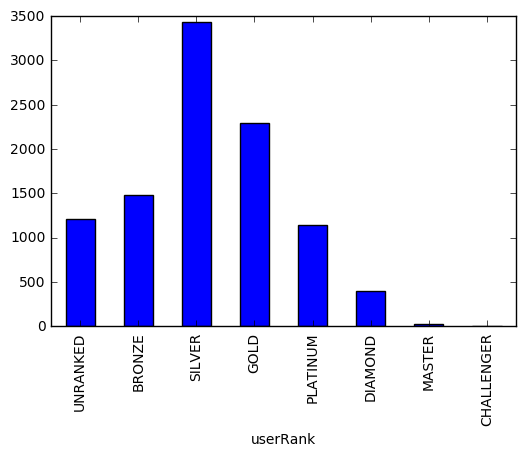

In [207]:
matchdf["userRank"] = matchdf["userRank"].astype('category').cat.set_categories(
    ["UNRANKED", "BRONZE", "SILVER", "GOLD", "PLATINUM", "DIAMOND", "MASTER", "CHALLENGER"], ordered=True)
matchdf.groupby(['userRank'])['userRank'].count().plot(kind='bar')
plt.show()

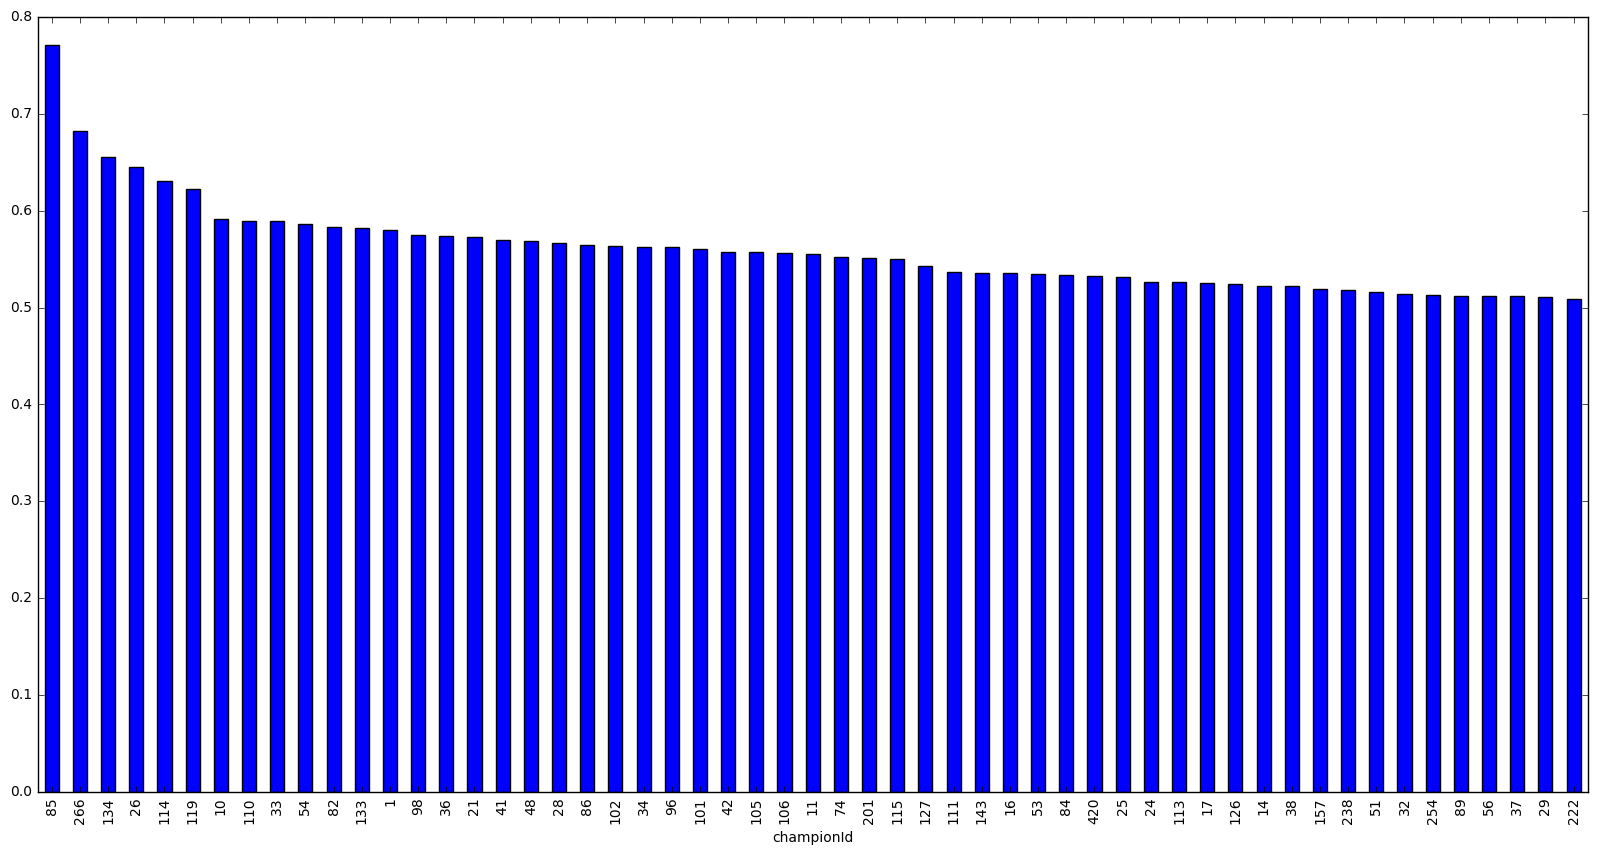

In [15]:
matchdf['winrate'] = matchdf.groupby('championId')['winner'].transform(np.mean)
matchdf[(matchdf['winrate'] > 0.5)].pivot_table(values='winrate', index='championId').sort_values(ascending=False). \
plot(kind='bar',figsize=(20,10))
plt.show()

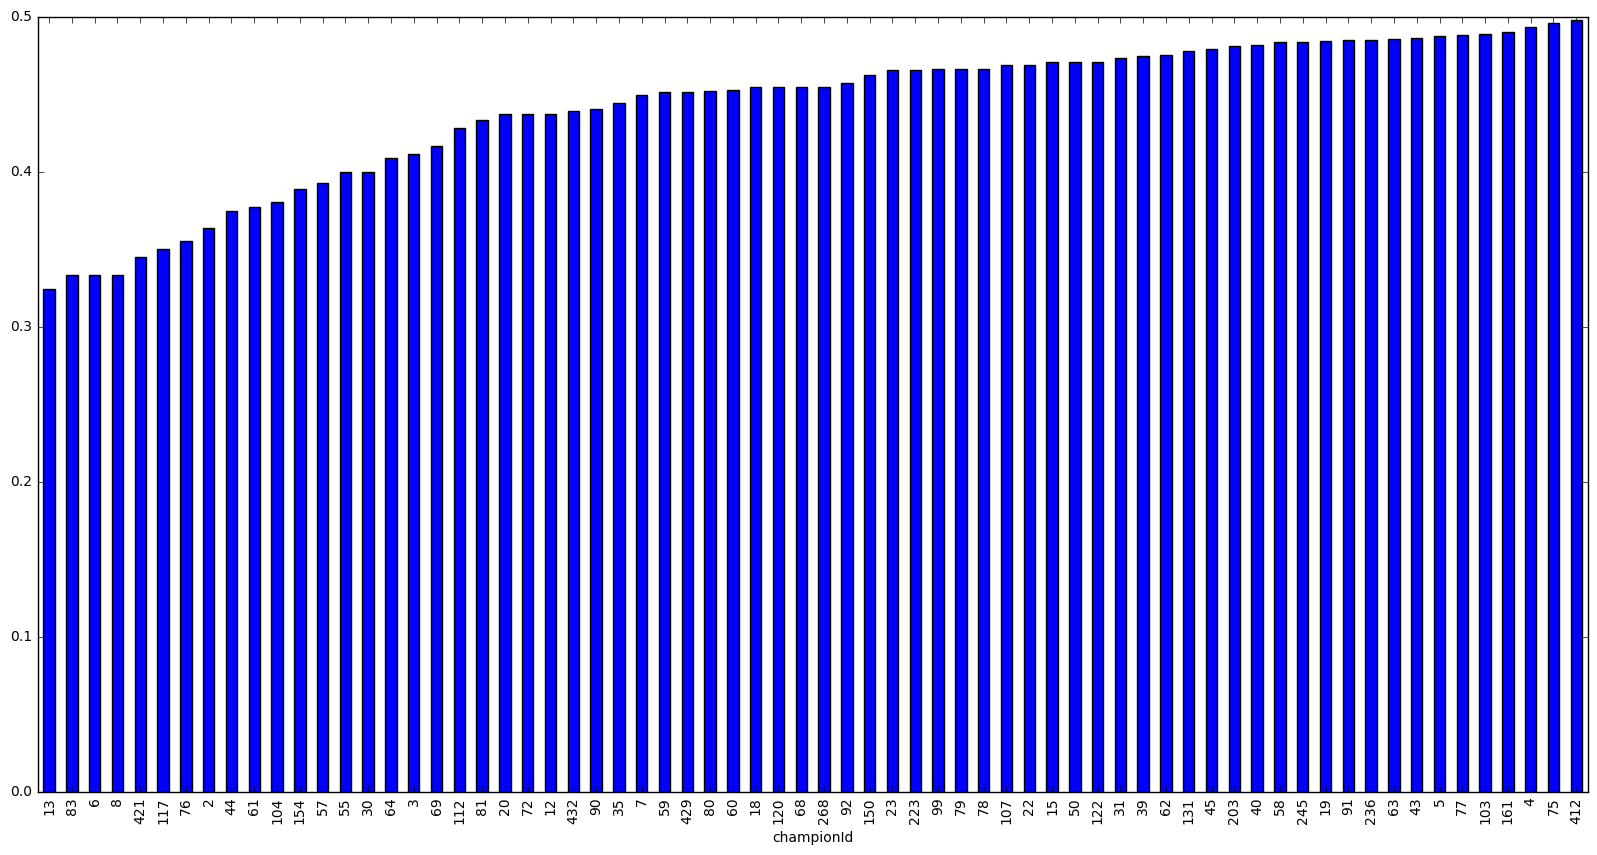

In [16]:
matchdf['winrate'] = matchdf.groupby('championId')['winner'].transform(np.mean)
matchdf[(matchdf['winrate'] < 0.5)].pivot_table(values='winrate', index='championId').sort_values(ascending=True). \
plot(kind='bar',figsize=(20,10))
plt.show()

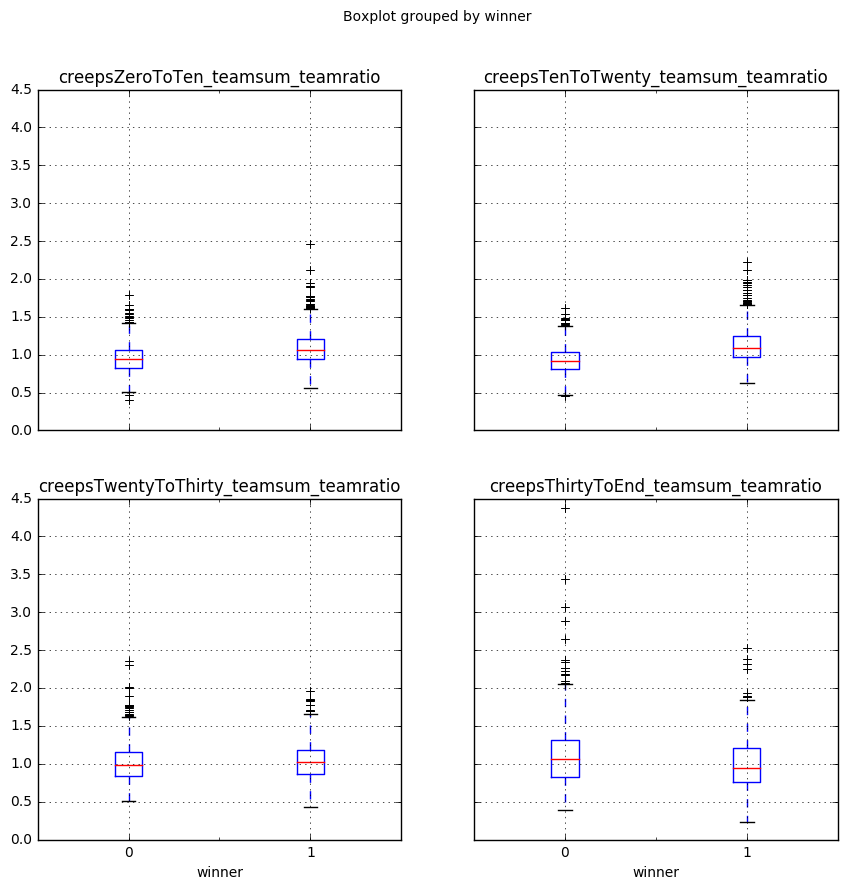

In [220]:
plotlist = ["creepsZeroToTen_teamsum_teamratio", "creepsTenToTwenty_teamsum_teamratio", 
            "creepsTwentyToThirty_teamsum_teamratio", "creepsThirtyToEnd_teamsum_teamratio"]

matchdf.boxplot(column=plotlist, by="winner", figsize=(10,10))
plt.show()

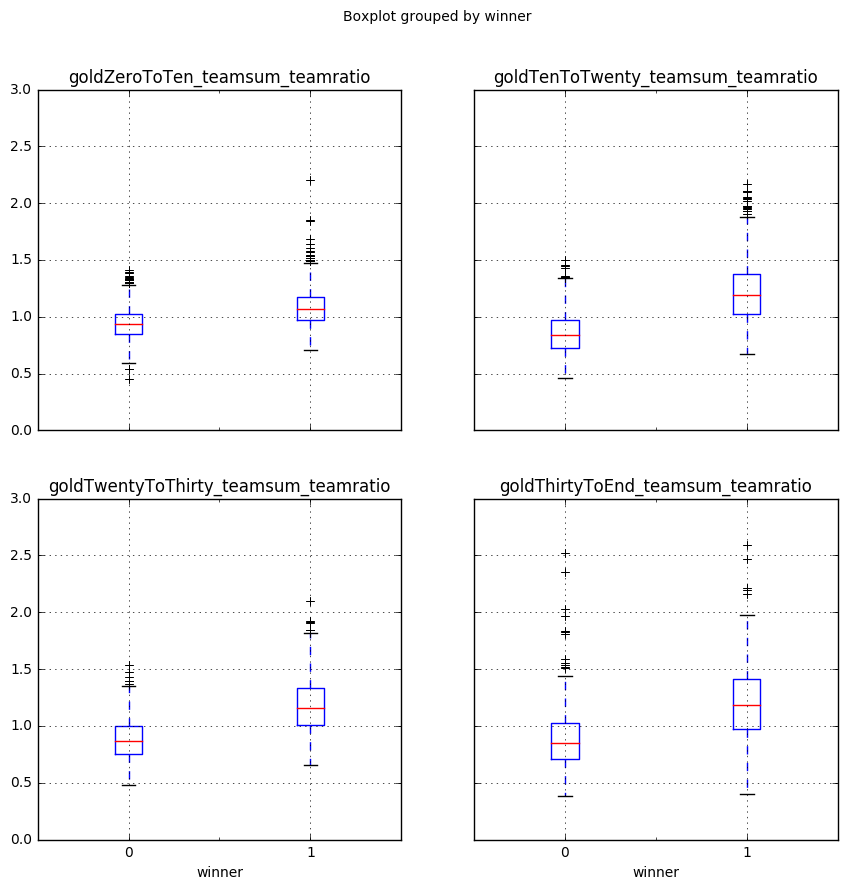

In [221]:
plotlist = ["goldZeroToTen_teamsum_teamratio", "goldTenToTwenty_teamsum_teamratio", 
            "goldTwentyToThirty_teamsum_teamratio", "goldThirtyToEnd_teamsum_teamratio"]

matchdf.boxplot(column=plotlist, by="winner", figsize=(10,10))
plt.show()

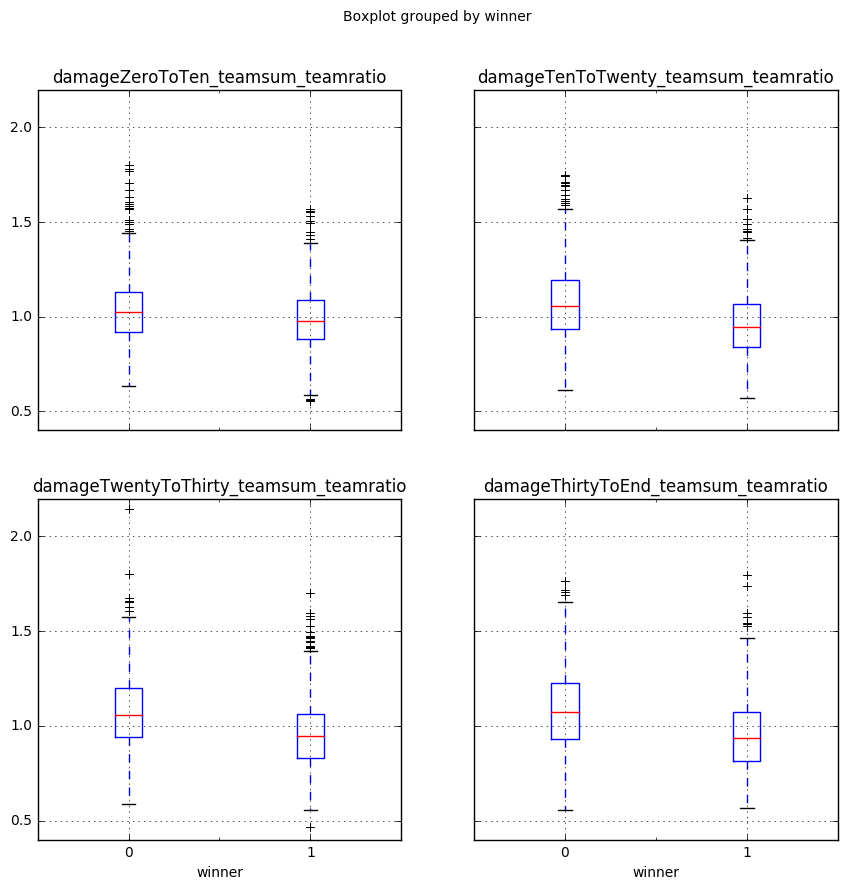

In [222]:
plotlist = ["damageZeroToTen_teamsum_teamratio", "damageTenToTwenty_teamsum_teamratio", 
            "damageTwentyToThirty_teamsum_teamratio", "damageThirtyToEnd_teamsum_teamratio"]

matchdf.boxplot(column=plotlist, by="winner", figsize=(10,10))
plt.show()

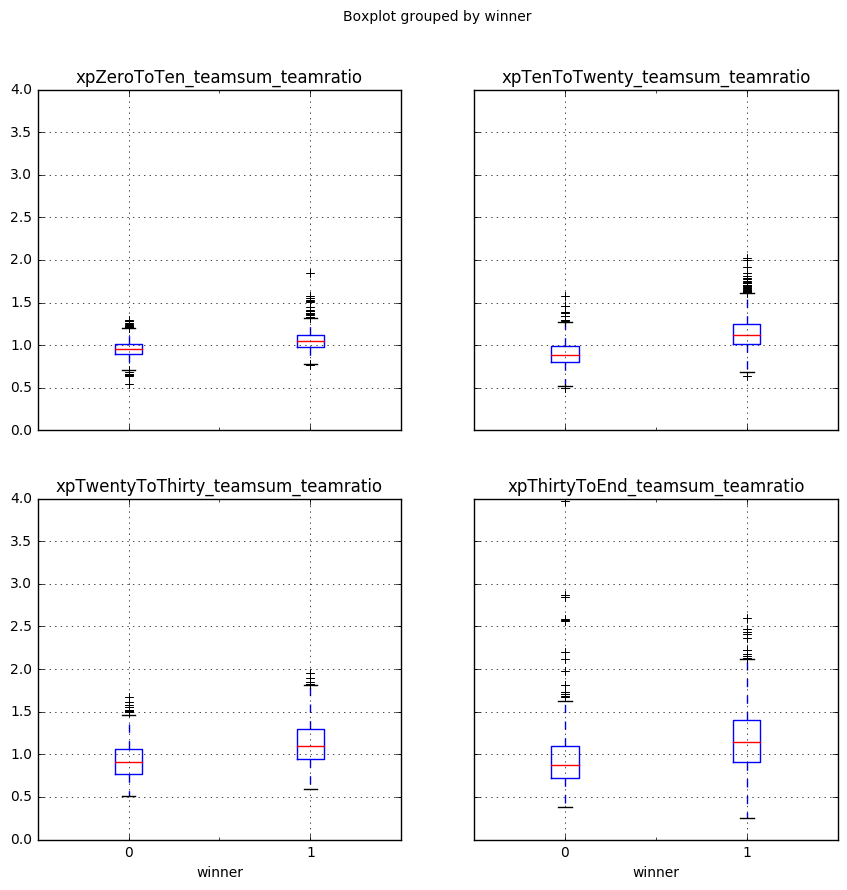

In [223]:
plotlist = ["xpZeroToTen_teamsum_teamratio", "xpTenToTwenty_teamsum_teamratio", 
            "xpTwentyToThirty_teamsum_teamratio", "xpThirtyToEnd_teamsum_teamratio"]

matchdf.boxplot(column=plotlist, by="winner", figsize=(10,10))
plt.show()